In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def densenet(input_shape, n_classes, filters=32):
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
        return x

    def dense_block(x, repetitions):
        for _ in range(repetitions):
            y = bn_rl_conv(x, 4 * filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y, x])
        return x

    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x

    input_layer = Input(input_shape)
    x = Conv2D(64, 3, strides=1, padding='same')(input_layer)  # Adjusted for 48x48 input
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for repetitions in [6, 12, 24, 16]:
        d = dense_block(x, repetitions)
        x = transition_layer(d)
    
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Setup paths
train_dir = '/home/darksst/Desktop/FinalProject/project_1_dataset/train'
test_dir = '/home/darksst/Desktop/FinalProject/project_1_dataset/test'

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=100,
    color_mode='grayscale',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

# Create the model
model = densenet((48, 48, 1), 7)  # 7 classes
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=100, validation_data=test_generator)


Found 22939 images belonging to 7 classes.
Found 5726 images belonging to 7 classes.
Epoch 1/100
230/230 [==============================] - 55s 94ms/step - loss: 1.8743 - accuracy: 0.2688 - val_loss: 2.0008 - val_accuracy: 0.2380
Epoch 2/100
230/230 [==============================] - 21s 91ms/step - loss: 1.6228 - accuracy: 0.3566 - val_loss: 2.0253 - val_accuracy: 0.3240
Epoch 3/100
230/230 [==============================] - 22s 94ms/step - loss: 1.4419 - accuracy: 0.4433 - val_loss: 1.7415 - val_accuracy: 0.3692
Epoch 4/100
230/230 [==============================] - 22s 94ms/step - loss: 1.3348 - accuracy: 0.4914 - val_loss: 82.6892 - val_accuracy: 0.1788
Epoch 5/100
230/230 [==============================] - 21s 91ms/step - loss: 1.2489 - accuracy: 0.5244 - val_loss: 1.5140 - val_accuracy: 0.4143
Epoch 6/100
230/230 [==============================] - 21s 89ms/step - loss: 1.1898 - accuracy: 0.5456 - val_loss: 1.4632 - val_accuracy: 0.4520
Epoch 7/100
230/230 [=======================

KeyboardInterrupt: 

In [12]:
'''NewDenseK = '/home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/CDense.keras'
NewDense = '/home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/CDense'
model.save(NewDense)
model.save(NewDenseK, save_format='keras')'''

INFO:tensorflow:Assets written to: /home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/CDense/assets


INFO:tensorflow:Assets written to: /home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/CDense/assets


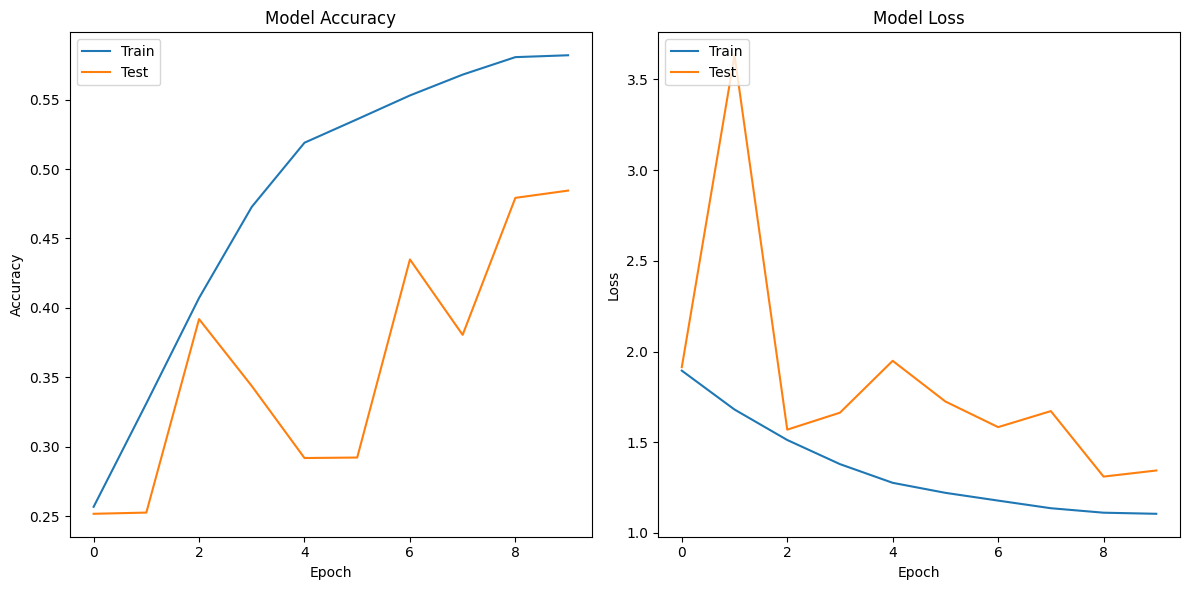

In [8]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()